# **Final Project**

dricci@ucsd.edu

916-792-2981

******************
*******************

# **Description of data**

I will be importing information about Apple's stock. My goal is to create buy and sell signals using Moving Average Convergence Divergence(MACD). Then, I will test the accuracy of these predictors using various Machine Learning techniques.
 


*******************
*******************
# **Libraries**

Below I use a new library named yfinance to import stock data instead of webscraping from the internet. This method has been approved by the professor and Brendon.

In [ ]:
!pip install yfinance
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import model_selection
from sklearn import tree
from sklearn import metrics
from sklearn.datasets import make_classification
import yfinance as yf
import random

*******************
*******************
# **Functions used in notebook**


## **Feature Engineering Fuctions**
Chronologically ordered by when the function is called in the notebook



### get_MACD(df)
A function that calculates the MACD for each entry in the dataset. The MACD trading signal was created in the 1970s by Gerald Appel, and is commonly used to this day. MACD was created to interpret trend direction, momentum, and reversals of stock price. MACD is calculated by subtracting the 26-day exponentially weighted mean(ewm) of price from the 12-day ewm of price. Then, a signal line is generated by taking the 9-day ewm of MACD. The signal line and MACD line are similar in shape, but the MACD line moves faster since the signal is the average of MACD.


**Psuedocode:**


```
def get_MACD(df):
  short_list = df['Close'].ewm(12 days)
  long_list = df['Close'].ewm(26 days)

  MACD = short_list - longlist
  Signal = df['MACD'].ewm(9 days)
  return df
```



In [ ]:
def get_MACD(df):
  '''
  A function that gets the MACD and Signal line for a particular stock

  Inputs:
    df: dataframe of stock that will be appended to in the function

  Outputs:
    df: original dataframe with MACD and Signal columns
  '''
  #find short list
  ewm1 = df['Close'].ewm(span=12, adjust=False).mean()
  #find long list
  ewm2 = df['Close'].ewm(span=26, adjust=False).mean()

  #create MACD column
  df['MACD'] = ewm1-ewm2
  #create Signal column
  df['Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()
  return df


### buy_sell(df)
This function is the brains of the operation. It will buy a share when the MACD rises above the signal, then sell immediately when the MACD dips below the signal. This function will also calculate the percent return whenever the stock is purchased, and will continue calculating the percent return for each entry until the stock is sold. The purpose of this is to be able to later test the accuracy of the sell signal. There are some limitations to this method. The main one being that as of now I cannot think of a way to calculate the accuracy of the buy signal with the way my data is manipulated.

**Psuedocode:**


```
def buy_sell(df):
  intitialize empty lists and variables
  for i in len(df):
    if df[MACD][i] > df[Signal][i]:
      if not bought:
        trigger buy event by updating initialized lists and varibales
      if bought:
        track percent return if sold at current price
    elif df[MACD][] < df[Signal][i]
      if bought:
        trigger sell event that will update percent return for the initial buy event
      if not bought:
        do nothing
    else:
      if bought:
        track percent return if sold at current price
      if not bought:
        do nothing
  return updated lists and variables

```



In [ ]:
def buy_sell(df):
  '''
  A function that determines buy and sell signals based on the behavior of the MACD and signal values

  Inputs:
    df = The dataframe of the desired stock 

  Outputs:
    These lists can be used to compute expected percent return of the simulated trades:
    sigBuyPrice = a list of the prices of the stock when a buy event occurs
    sigSellPrice = a list of the prices of the stock when a sell event occurs

    These lists will be used to create columns in the original dataset:
    percentReturn: A list of values that correspond to the percent return if sold at current price
    binBuySig: A list of binary values that signal a buy event
    binSellSig: A list of binary values that signal a sell event
  '''
  #initialize empty lists and variables to later append to
  sigBuyPrice = []
  sigSellPrice = []
  binBuySig = []
  binSellSig = []
  temp_buyPrice = 0
  percentReturn = []
  bought = False

  #for loop that will create buy and sell signals
  for i in range(len(df)):

    #Checks if MACD is greater than the signal
    if df['MACD'][i] > df['Signal'][i]:

      #also checks if the stock has been bought 
      if bought == False:
        #if it has not been bought a buy event occurs
        sigBuyPrice.append(df['Close'][i])
        binBuySig.append(1)
        binSellSig.append(0)
        temp_buyPrice = df['Close'][i]
        percentReturn.append(0)
        bought = True

      else:
        #if it has been bought only potential percent return is updated
        binBuySig.append(0)
        binSellSig.append(0)
        percentReturn.append(((df['Close'][i] - temp_buyPrice)/temp_buyPrice)*100)

    #Checks if MACD is less than the signal
    elif df['MACD'][i] < df['Signal'][i]:

      #also checks if the stock has been bought 
      if bought:
        #if it has been bought a sell event occurs
        binBuySig.append(0)
        binSellSig.append(1)
        sigSellPrice.append(df['Close'][i])
        percentReturn.append(((df['Close'][i] - temp_buyPrice)/temp_buyPrice)*100)
        bought = False

      else:
        #if it has not been bought nothing happens
        percentReturn.append(0)
        binBuySig.append(0)
        binSellSig.append(0)

    #Checks if MACD is equal to the signal
    else:

      #also checks if the stock has been bought 
      if bought:
        #if it has been bought only potential percent return is updated
        percentReturn.append(((df['Close'][i] - temp_buyPrice)/temp_buyPrice)*100)
        binBuySig.append(0)
        binSellSig.append(0)

      else:
        #if it has not been bought nothing happens
        percentReturn.append(0)
        binBuySig.append(0)
        binSellSig.append(0)
  
  return (sigBuyPrice, sigSellPrice, percentReturn, binBuySig, binSellSig)


## **Machine Learning Function**

### binary_class(X,y,plots = True, depth = 1)

I will later use this function to see if MACD can be a predictor of profit. MACD will be split into critereon and tested, profit will be the binary result. The reson I put this as a function is to test max depth.

**Psuedocode:**


```
def binary_class(Independent Variable, Dependent Variable, plots, depth):
  train_test_split(X,y)
  declare tree_model with max_depth = depth
  tree_model.fit(Xtrain,ytrain)
  accuracy = tree_model.score(Xtest,ytest)
  y_predicted = tree_model.predict(Xtest)
  get TP, TN, FP, FN
  calculate F1-score

  if plots == True:
    return ROC and Boxplot

  return accuracy, F1, and tree_model

```



In [ ]:
def binary_class(X,y,plots = True,depth = 1):
  '''
  A function that uses the decision tree model to show plots, accuracy, and f1 score.
  Inputs:
    X = Independent Dataframe
    y = Dependent Dataframe
    plots = boolean operator that decides if plots are shown
  
  Outputs
    accuracy = Test Accuracy
    F1 = Test F1-Score
    tree_model = Decision Tree Model
    If plots is true then outputs subplot
  '''

  #split the data set random state equal to 1 to make observations
  Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state = 1)

  #create decision tree for train using max depth of 2 since it is a better fit
  tree_model = tree.DecisionTreeClassifier(max_depth=depth)

  #fit to decision tree
  tree_model.fit(Xtrain, ytrain)

  #create decision tree for train using max depth of 2 since it is a better fit
  accuracy = tree_model.score(Xtest, ytest)

  #find the predicted y value
  y_predicted = tree_model.predict_proba(Xtest)[:,1]

  #get true positive, false negative, etc and calculate F1
  tn, fp, fn, tp = metrics.confusion_matrix(ytest,tree_model.predict(Xtest)).ravel()
  F1 = (2*tp)/(2*tp+fn+fp)

  #if statement for plots input
  if plots == True:

    #create subplot
    fig, ax = plt.subplots(2,1,figsize=[10,10])

    #create boxplot for y,X
    sns.boxplot(ax = ax[0],x = y,y = X[X.columns[0]])
    ax[0].set_title('Boxplot')

    #create ROC curve
    fpr, tpr, thresholds = metrics.roc_curve(ytest,y_predicted)   
    ax[1].plot(fpr,tpr,marker='o')
    ax[1].plot([0,1],[0,1])
    ax[1].set_xlabel('False Positive Rate')
    ax[1].set_ylabel('True Positive Rate')
    ax[1].set_title('ROC')

    
  return accuracy, F1, tree_model

*******************
*******************
# **Getting data**


Import the dataset using yfinance

In [ ]:
#Change the parameters below to change data
df = yf.download(tickers='BTC-USD',period = '1d', interval = '1m')

[*********************100%***********************]  1 of 1 completed


Show the first 5 entries. The head of the dataset is the furthest dates as expected.

In [ ]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Datetime,,,,,,
2021-09-29 00:00:00+01:00,41591.687500,41591.687500,41591.687500,41591.687500,41591.687500,0
2021-09-29 00:01:00+01:00,41606.769531,41606.769531,41606.769531,41606.769531,41606.769531,0
2021-09-29 00:02:00+01:00,41617.105469,41617.105469,41617.105469,41617.105469,41617.105469,964608
2021-09-29 00:03:00+01:00,41608.175781,41608.175781,41608.175781,41608.175781,41608.175781,0
2021-09-29 00:04:00+01:00,41620.632812,41620.632812,41620.632812,41620.632812,41620.632812,0


Show the last 5 entries. The tail of the dataset is the most recent dates as expected.

In [ ]:
df.tail()

,Open,High,Low,Close,Adj Close,Volume
Datetime,,,,,,
2021-09-29 10:04:00+01:00,42246.757812,42246.757812,42246.757812,42246.757812,42246.757812,0
2021-09-29 10:05:00+01:00,42238.730469,42238.730469,42238.730469,42238.730469,42238.730469,706560
2021-09-29 10:06:00+01:00,42283.246094,42283.246094,42283.246094,42283.246094,42283.246094,1220608
2021-09-29 10:07:00+01:00,42292.886719,42292.886719,42292.886719,42292.886719,42292.886719,111263744
2021-09-29 10:08:02+01:00,42282.691406,42282.691406,42282.691406,42282.691406,42282.691406,0


Show the info of the dataset. All columns are numerical values and there are no null entries. Even though we go back a year, yfinance does not have entries when the market is closed, thus why the number of entries each column are less than 356.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 557 entries, 2021-09-29 00:00:00+01:00 to 2021-09-29 10:08:02+01:00
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       557 non-null    float64
 1   High       557 non-null    float64
 2   Low        557 non-null    float64
 3   Close      557 non-null    float64
 4   Adj Close  557 non-null    float64
 5   Volume     557 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 30.5 KB


Somewhat interesting information as the description of the dataset shows the statistics of the stock price.

In [ ]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,557.000000,557.000000,557.000000,557.000000,557.000000,5.570000e+02
mean,41931.978407,41931.978407,41931.978407,41931.978407,41931.978407,1.275993e+07
std,434.556292,434.556292,434.556292,434.556292,434.556292,1.475447e+08
min,40829.667969,40829.667969,40829.667969,40829.667969,40829.667969,0.000000e+00
25%,41611.824219,41611.824219,41611.824219,41611.824219,41611.824219,0.000000e+00
50%,42042.296875,42042.296875,42042.296875,42042.296875,42042.296875,0.000000e+00
75%,42321.703125,42321.703125,42321.703125,42321.703125,42321.703125,5.431296e+06
max,42490.160156,42490.160156,42490.160156,42490.160156,42490.160156,3.468237e+09


***************
***************
# **Visualizing data**

## OHLC Price over Time
Show how the price behaved over the course of the dataset.

**Psuedocode:**


```
stock_df = df.copy()
stock_df['OHLC Average'] = the average of the open, high, low, and close price
plot(stock_df.index, stock_df['OHLC Average']
add markers, titles, and labels
```



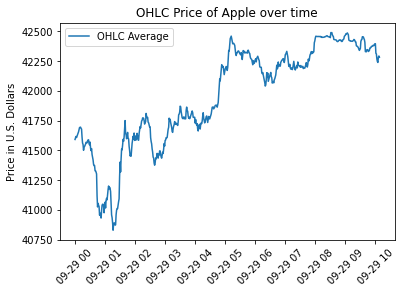

In [ ]:
#create new dataframe
stock_df = df.copy()

#creates a new column named OHLC Average which is the Open, High, Low, Close Average Price
stock_df['OHLC Average'] = round(((df['Open'] + df['Close'] + df['High'] + df['Low'])/ 4), 2)

#create plot
plt.plot(stock_df.index, stock_df['OHLC Average'], label = 'OHLC Average')

#gives the graph title, labels, etc
plt.xticks(rotation=45)
plt.legend(loc='best')
plt.title('OHLC Price of Apple over time')
plt.ylabel('Price in U.S. Dollars');

## The CDF of the Daily Percent Change in Price

The CDF of the OHLC Average could be interesting as it shows the expected behaviour of the stock price.

**Psuedocode:**

```
stock_df['Returns'] = daily percent change in stock
fill the first entry with mean since it will be null
create kde plot of stock_df['Returns']
title and label plot
show plot
```



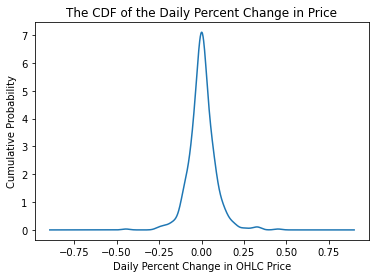

In [ ]:
#creates a new column named Returns which is daily percent change in a stock
stock_df['Returns'] = (((stock_df['OHLC Average']/stock_df['OHLC Average'].shift(1)) - 1)*100)
  
#fills null values with mean since the only null value will be the first entry of the dataframe, due to the formula
stock_df['Returns'] = stock_df['Returns'].fillna(stock_df['Returns'].mean())

#sets the graph as a density estimation of the return column
y = stock_df['Returns'].plot(kind='kde')

#gives the graph title, and labels.
plt.title('The CDF of the Daily Percent Change in Price')
plt.xlabel('Daily Percent Change in OHLC Price')
plt.ylabel('Cumulative Probability')


plt.show()

## MACD, Signal, and Close Price over time

This graph shows how price behaves with the Signal and MACD line. We can see the the MACD and Signal line seem to increase and decrease with price. This block will also contain our first bit of feature engineering, which is generating columns which correspond to the MACD and Signal values. The Psuedocode for this feature engineering is in the functions section above.

**Psuedocode:**

```
get_MACD(df)
create plot of price over time
add MACD and signal to plot
add legends, labels, and titles
show plot
```



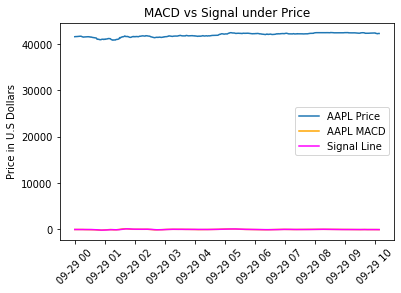

In [ ]:
#call function to add new columns to df
get_MACD(df)

#plot the Closing Price, MACD, and Signal over time
plt.plot(df.index, df['Close'], label='AAPL Price')
plt.plot(df.index, df['MACD'], label='AAPL MACD', color='orange')
plt.plot(df.index, df['Signal'], label='Signal Line', color='Magenta')

#gives the graph title, labels, etc.
plt.legend(loc='best')
plt.xticks(rotation=45)
plt.ylabel('Price in U.S Dollars')
plt.title('MACD vs Signal under Price');

## MACD and Signal over Time

This is a more zoomed in picture with what is happening between the MACD and Signal line which is what we are interested in most for generating our buy and sell signals. Our buy events will occur the first instance that MACD > Signal and our sell events will occur when MACD < Signal.

**Psuedocode:**

```
create plot of MACD and Signal over time
add labels, titles, and legend
show plot
```



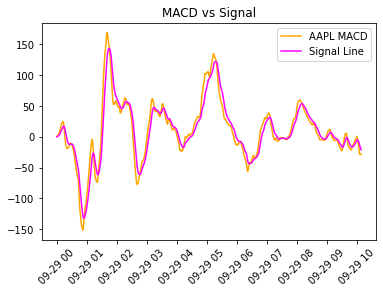

In [ ]:
#plot only MACD and Signal over time
plt.plot(df.index, df['MACD'], label='AAPL MACD', color = 'orange')
plt.plot(df.index, df['Signal'], label='Signal Line', color='magenta')

#gives the graph title, labels, etc.
plt.legend(loc='best')
plt.xticks(rotation=45)
plt.title('MACD vs Signal');

## Scatterplot of MACD as the predictor of Close Price



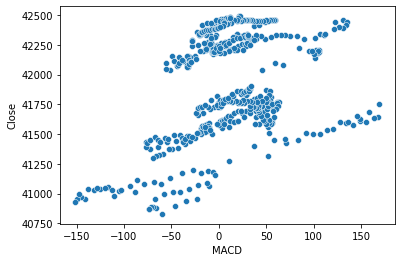

In [ ]:
sns.scatterplot(x = df['MACD'],y = df['Close']);

This is a very interesting relationship between MACD and Close. Although there seems to be some sort of pattern between these two variables, it seems like there is a lot of error. This is expected since the value of MACD doesn't necassarily mean the price is high. MACD will be higher not when the price is high, but when the price is realtively high compared to the prices before.

## Scatterplot of the difference between MACD and Signal as the predictor of Close Price


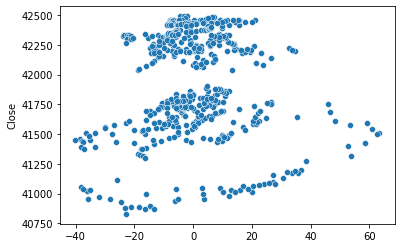

In [ ]:
sns.scatterplot(x = df['MACD']-df['Signal'], y = df['Close']);

Nice, this graph seems to have less error which makes sense. The relationship between MACD and Signal is a stronger indicator of price. There is still some error though and that is for the same reason above. The MACD and Signal only show if the price is relatively high or low. We will come back to this idea of MACD as a predictor later.

***************
***************
# **Feature Engineering**

The bulk of my feature engineering is creating buy and sell signals. The first bit of feature engineering is already done above when generating the MACD and Signal values using the get_MACD() function.



The main part of my feature engineering is creating buy and sell signals using the buy_sell() function. This block of code will add columns to the main dataframe. These columns are Percent Return, Profit, Buy Signal, and Sell Signal. Percent Return, Buy Signal, and Sell Signal have all been described above. Profit is a binary column where if percent return > 0, then the column will display 1. The buyList and sellList will be used to calculate overall performace statistics later.

In [ ]:
#call function to create columns and lists
buyList, sellList, df['Percent Return'], df['Buy Signal'], df['Sell Signal'] = buy_sell(df)

#create new profit column
df['Profit'] = df['Percent Return'] > 0

#make new column binary
df['Profit'] = df['Profit'].astype(int)

#display new dataframe
pd.set_option('display.max_rows', None)
df

,Open,High,Low,Close,Adj Close,Volume,MACD,Signal,Percent Return,Buy Signal,Sell Signal,Profit
Datetime,,,,,,,,,,,,
2021-09-29 00:00:00+01:00,41591.687500,41591.687500,41591.687500,41591.687500,41591.687500,0,0.000000,0.000000,0.000000,0,0,0
2021-09-29 00:01:00+01:00,41606.769531,41606.769531,41606.769531,41606.769531,41606.769531,0,1.203125,0.240625,0.000000,1,0,0
2021-09-29 00:02:00+01:00,41617.105469,41617.105469,41617.105469,41617.105469,41617.105469,964608,2.956553,0.783811,0.024842,0,0,1
2021-09-29 00:03:00+01:00,41608.175781,41608.175781,41608.175781,41608.175781,41608.175781,0,3.584288,1.343906,0.003380,0,0,1
2021-09-29 00:04:00+01:00,41620.632812,41620.632812,41620.632812,41620.632812,41620.632812,0,5.028980,2.080921,0.033320,0,0,1
2021-09-29 00:05:00+01:00,41633.773438,41633.773438,41633.773438,41633.773438,41633.773438,1896448,7.151807,3.095098,0.064903,0,0,1
2021-09-29 00:06:00+01:00,41648.109375,41648.109375,41648.109375,41648.109375,41648.109375,4397056,9.877095,4.451497,0.099358,0,0,1
2021-09-29 00:07:00+01:00,41655.980469,41655.980469,41655.980469,41655.980469,41655.980469,0,12.527626,6.066723,0.118276,0,0,1
2021-09-29 00:08:00+01:00,41675.539062,41675.539062,41675.539062,41675.539062,41675.539062,4067328,16.021718,8.057722,0.165284,0,0,1


Lets make sure when I added these columns there are no null values, incompatable dtypes, or other errors. Everything seems to still be fine.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 557 entries, 2021-09-29 00:00:00+01:00 to 2021-09-29 10:08:02+01:00
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Open            557 non-null    float64
 1   High            557 non-null    float64
 2   Low             557 non-null    float64
 3   Close           557 non-null    float64
 4   Adj Close       557 non-null    float64
 5   Volume          557 non-null    int64  
 6   MACD            557 non-null    float64
 7   Signal          557 non-null    float64
 8   Percent Return  557 non-null    float64
 9   Buy Signal      557 non-null    int64  
 10  Sell Signal     557 non-null    int64  
 11  Profit          557 non-null    int64  
dtypes: float64(8), int64(4)
memory usage: 56.6 KB


Lets look at the overall performance of this strategy by looking at the variance and mean of the percent return of these trades.

**Psuedocode:**


```
pRlist = []
for i in len(buyList):
  prList.append(Percent Return calc using buyList and sellList
print mean and standard deviation
```

Woah, that is a lot of variance which is concerning. On the bright side of things the mean is positive which shows the algorithm isn't useless. Sadly, the percent return of buying and holding the stock on the start date is higher making the algorithm semi-useless. Is this because the MACD strategy is flawed or because the algorithm is inefficient?


In [ ]:
#find performance of strategy
pR_list = []

#iterated for the range of the buyList
#NOTE: this will not work if len(buyList) != len(sellList)
for i in range(len(sellList)):

  #append percent change in each trade to list
  pR_list.append(((sellList[i] - buyList[i])/buyList[i])*100)

#get statistics of list
ovr_Perf = np.mean(pR_list)
std_Perf = np.std(pR_list)

#print statistics
print('Expected Percent Return of Algo:', ovr_Perf)
print('Standard Deviation of Returns:', std_Perf)

Expected Percent Return of Algo: 0.20100279550311642
Standard Deviation of Returns: 0.5537243279528978


***************
***************
# **Analysis section**

So, lets figure out why our trades are not optimal. First we will look at the algorithm, then at the strategy to find out which is the bottleneck.

## Machine Learning

### Hold-Out Binary Classification with Sell Signal as a predictor of Profit

Let us first check our sell signals, we are going to check the accuracy and the f1 of a split of data to see if our sell signal is a good predictor of a profitable trade.

**Psuedocode**


```
train_test_split(df['Sell Signal], df[Profit], random_state = 1)
get TP, TN, FP, FN of test data
calculate accuracy and F1 of test data
print accuracy and F1 of test data
```

In [ ]:
Xtrain, Xtest, ytrain, ytest = train_test_split(df['Sell Signal'],df['Profit'],random_state = 1)

#get our frequencies of true positives, flase negatives, etc
TP = sum((ytest==1) & (Xtest==1))
FP = sum((ytest==0) & (Xtest==1))
TN = sum((ytest==0) & (Xtest==0))
FN = sum((ytest==1) & (Xtest==0))

#calculate accuracy and F1
accuracy = (TP+TN)/(TP+TN+FP+FN)
F1 = (2*TP)/(2*TP+FN+FP)

#print accuracy and F1
print('Accuracy:', accuracy)
print('F1-Score: ', F1)

Accuracy: 0.6214285714285714
F1-Score:  0.0



Yikes, this is definitley concerning as the accuracy is sub-par and the F1-Score is terrible. Why is this? Well, the F1-score is bad since there is a lot of false negatives in the dataset since if the stock is not purchased, then the percent return is not calculated for that row. Lets check out the relationship between MACD and Profit to see why accuracy is low.


### Hold-Out Decision Tree Classification

Lets look to see if a certain critereon of MACD is a good predictor of profit. Psuedocode is provided in the binary_class function.

NOTE: When the stock is not bought the profit is automatically zero, thus these accuracies indicate if the stock is bought what MACD values will predict profit.



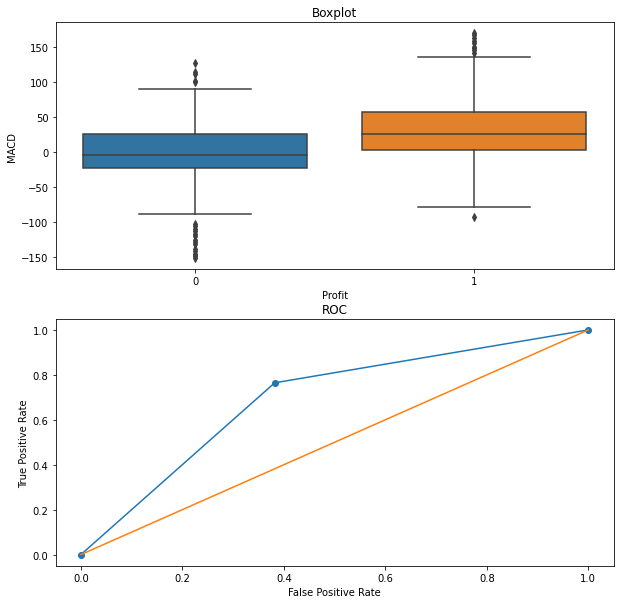

In [ ]:
test_AC, test_F1, tree_model, = binary_class(X = df[['MACD']],y = df['Profit'],plots = True, depth = 1)

Testing Accuracy: 0.6714285714285714
Testing F1: 0.6290322580645161


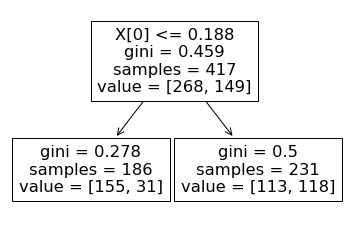

In [ ]:
#print info form function
print('Testing Accuracy:', test_AC)
print('Testing F1:', test_F1)
tree.plot_tree(tree_model);

Cool, it seems that if the stock is bought and MACD is greater than 2.236 there would be an 80% chance of profit. The tree is also relatively simple, so the critereon should not be overfitted. This shows that the issue doesnt seem to be the MACD strategy, but with the sell signal. This makes sense as well, the buy or sell signal is not triggered at an optimal time since the MACD stategy suggests that the buy and sell points are at the intercept of the MACD and Signal line. To find these intercepts we would need live stock data.

## Cross Validation

### Repeated Train Test using Logistic Regression

Just to make sure that our data regarding the accuracy of the sell signal is not biased because of the test data randomly allocated.

**Psuedocode**


```
model = LogisticRegression()
shufflesplit(n-splits=1000, random_state=0)
results = cross_validate(model)
print results
```

Woah there is a lot of variance. Also, this is interesting as it seems like the F1-score of the first hold-out was biased. The F1 score seems to be lower than we expected.

In [ ]:
#declare model as LogisticRegression
model = LogisticRegression()

#initialize shuffle split
shufflesplit = model_selection.ShuffleSplit(n_splits=1000, random_state=0)

#get results from cross validation
results = model_selection.cross_validate(model, df[['Sell Signal']], df['Profit'], cv=shufflesplit, return_train_score=True, scoring=('f1','accuracy'))

#print statistics about results
print('Mean Accuracy:', results['test_accuracy'].mean())
print('Standard Deviation:', results['test_accuracy'].std())
print('')
print('Mean F1:', results['test_f1'].mean())
print('Standard Deviation:', results['test_f1'].std())

Mean Accuracy: 0.6381785714285715
Standard Deviation: 0.06159382878907561

Mean F1: 0.0
Standard Deviation: 0.0


**Histogram Visualisation of the Accuracy**

This graph shows there are instances of our accuracy being extremely high or extremely low depending on the test data set, also showing our sell signal is inconsistant.

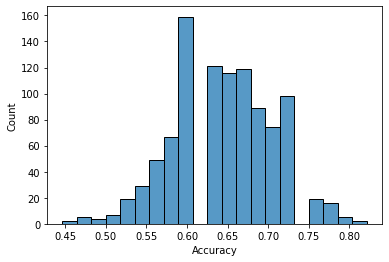

In [ ]:
sns.histplot(results['test_accuracy'])
plt.xlabel('Accuracy');

**Histogram Visualisation of the F1-Score**

This graph is the most interesting as it shows that our F1-score seems to be bounded to exteremly low values, also it seems like it is most common for the F1-Score to be near zero. This makes sense again as my sell signal produces a lot of false negatives.

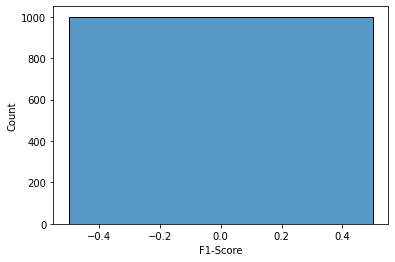

In [ ]:
sns.histplot(results['test_f1'])
plt.xlabel('F1-Score');

***************
***************
# **Conclusions**

In conclusion, although the algorithm produces positive returns after a one year period of time, through analysis we can see that our Sell Signal is inconsistant and inefficient. It was inconsistant due to the high variation in both the accuracy and F1-Score during cross validation, and inefficient due to being out performed by the stock itself. We also proved that the issue wasn't necassarily within the MACD strategy, but within the sell signals. One thing the program doesn't account for is the accuracy of a buy signal. Finding the accuracies of a buy signal seems more involved.

Although I am very happy that I was able to find some sort of predictor that produces profit, the predictor needs much improvement. After the submission of this final I will continue to mess with this notebook, and maybe get some better signals and strategies.